In [ ]:

%matplotlib inline
%pprint
from astropy import coordinates
from astropy.time import Time
from cartopy import crs
from pytz import timezone
from skyfield import almanac
from skyfield.almanac import find_discrete, seasons
from skyfield.api import wgs84, load
import astropy.units as u
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np

In [1]:

# Define the time range
ts = load.timescale()
t0 = ts.now()
t1 = ts.utc(t0.utc_datetime().year + 1, t0.utc_datetime().month, t0.utc_datetime().day)

# Compute the seasons (equinoxes and solstices)
eph = load('de421.bsp')
times, events = find_discrete(t0, t1, seasons(eph))

# Define the dates for solstices and equinoxes
event_names = {
    0: "Spring Equinox",
    1: "Summer Solstice",
    2: "Fall Equinox",
    3: "Winter Solstice",
}

# Define the dates for solstices and equinoxes
solstices_equinoxes = {event_names[e]: t.utc_datetime() for t, e in zip(times, events)}

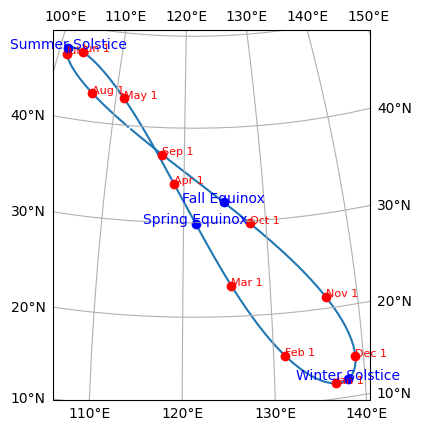

In [2]:

# Generate an analemma for now in Boston

# Generate time array for the year
time = Time.now() + np.arange(365) * u.day
location = coordinates.EarthLocation.of_address("Boston")
frame = coordinates.AltAz(obstime=time, location=location)

# Extract latitude and longitude in degrees
latitude = location.lat.deg
longitude = location.lon.deg

sun = coordinates.get_body("sun", time=time).transform_to(frame)

alt = sun.alt.deg
az = sun.az.deg

projection = crs.Orthographic(az.mean(), alt.mean())

fig, ax = plt.subplots(subplot_kw=dict(projection=projection))
ax.plot(az, alt, transform=crs.PlateCarree(), label="Analemma")

# Highlight the 1st of each month
for i in range(1, 366):
    if time[i-1].datetime.day == 1:
        ax.plot(az[i-1], alt[i-1], 'ro', transform=crs.PlateCarree())
        ax.text(az[i-1], alt[i-1], time[i-1].strftime('%b 1'), color='red',
                fontsize=8, transform=crs.PlateCarree())

# Label the solstices and equinoxes
for event, date_str in solstices_equinoxes.items():
    event_time = Time(date_str, format='datetime')
    idx = np.argmin(np.abs(time - event_time))
    ax.plot(az[idx], alt[idx], 'bo', transform=crs.PlateCarree())
    ax.text(az[idx], alt[idx], event, color='blue', fontsize=10, ha='center',
            transform=crs.PlateCarree())

ax.gridlines(draw_labels=True)

# Save the plot as an SVG file
svg_filename = "../saves/svg/analemma.svg"
fig.savefig(svg_filename, format='svg')

plt.show()

In [3]:

# When is sundown today?

# Figure out local midnight
zone = timezone('US/Eastern')
now = zone.localize(dt.datetime.now())
midnight = now.replace(hour=0, minute=0, second=0, microsecond=0)
next_midnight = midnight + dt.timedelta(days=1)

ts = load.timescale()
t0 = ts.from_datetime(midnight)
t1 = ts.from_datetime(next_midnight)
topos = wgs84.latlon(latitude, longitude)
f = almanac.dark_twilight_day(eph, topos)
times, events = almanac.find_discrete(t0, t1, f)

previous_e = f(t0).item()
for t, e in zip(times, events):
    tstr = str(t.astimezone(zone))[:16]
    if previous_e < e:
        print(tstr, ' ', almanac.TWILIGHTS[e], 'starts')
    else:
        print(tstr, ' ', almanac.TWILIGHTS[previous_e], 'ends')
    previous_e = e

2024-08-20 04:12   Astronomical twilight starts
2024-08-20 04:51   Nautical twilight starts
2024-08-20 05:27   Civil twilight starts
2024-08-20 05:57   Day starts
2024-08-20 19:36   Day ends
2024-08-20 20:06   Civil twilight ends
2024-08-20 20:42   Nautical twilight ends
2024-08-20 21:20   Astronomical twilight ends
